In [1]:
pip install ucimlrepo numpy pandas matplotlib scikit-learn seaborn autograd torch tabulate

Note: you may need to restart the kernel to use updated packages.


In [2]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
support2 = fetch_ucirepo(id=880)

# data (as pandas dataframes)
X = support2.data.features
y = support2.data.targets

# metadata
print(support2.metadata)

# variable information
print(support2.variables)

{'uci_id': 880, 'name': 'SUPPORT2', 'repository_url': 'https://archive.ics.uci.edu/dataset/880/support2', 'data_url': 'https://archive.ics.uci.edu/static/public/880/data.csv', 'abstract': "This dataset comprises 9105 individual critically ill patients across 5 United States medical centers, accessioned throughout 1989-1991 and 1992-1994.\nEach row concerns hospitalized patient records who met the inclusion and exclusion criteria for nine disease categories: acute respiratory failure, chronic obstructive pulmonary disease, congestive heart failure, liver disease, coma, colon cancer, lung cancer, multiple organ system failure with malignancy, and multiple organ system failure with sepsis. The goal is to determine these patients' 2- and 6-month survival rates based on several physiologic, demographics, and disease severity information. \nIt is an important problem because it addresses the growing national concern over patients' loss of control near the end of life. It enables earlier deci

In [ ]:
# support2.variables.to_csv("support2_codebook.csv", index=False)

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
data = pd.concat([X,y],axis=1)
data

,age,sex,dzgroup,dzclass,num.co,edu,income,scoma,charges,totcst,...,ph,glucose,bun,urine,adlp,adls,adlsc,death,hospdead,sfdm2
0,62.84998,male,Lung Cancer,Cancer,0,11.0,$11-$25k,0.0,9715.0,NaN,...,7.459961,NaN,NaN,NaN,7.0,7.0,7.000000,0,0,NaN
1,60.33899,female,Cirrhosis,COPD/CHF/Cirrhosis,2,12.0,$11-$25k,44.0,34496.0,NaN,...,7.250000,NaN,NaN,NaN,NaN,1.0,1.000000,1,1,<2 mo. follow-up
2,52.74698,female,Cirrhosis,COPD/CHF/Cirrhosis,2,12.0,under $11k,0.0,41094.0,NaN,...,7.459961,NaN,NaN,NaN,1.0,0.0,0.000000,1,0,<2 mo. follow-up
3,42.38498,female,Lung Cancer,Cancer,2,11.0,under $11k,0.0,3075.0,NaN,...,NaN,NaN,NaN,NaN,0.0,0.0,0.000000,1,0,no(M2 and SIP pres)
4,79.88495,female,ARF/MOSF w/Sepsis,ARF/MOSF,1,NaN,NaN,26.0,50127.0,NaN,...,7.509766,NaN,NaN,NaN,NaN,2.0,2.000000,0,0,no(M2 and SIP pres)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9100,66.07300,male,ARF/MOSF w/Sepsis,ARF/MOSF,1,8.0,NaN,0.0,52870.0,34329.3125,...,7.459961,188.0,21.0,NaN,NaN,0.0,0.000000,0,0,NaN
9101,55.15399,female,Coma,Coma,1,11.0,NaN,41.0,35377.0,23558.5000,...,7.289062,190.0,49.0,0.0,NaN,0.0,0.000000,0,0,NaN
9102,70.38196,male,ARF/MOSF w/Sepsis,ARF/MOSF,1,NaN,NaN,0.0,46564.0,31409.0156,...,7.379883,189.0,60.0,3900.0,NaN,NaN,2.525391,0,0,NaN
9103,47.01999,male,MOSF w/Malig,ARF/MOSF,1,13.0,NaN,0.0,58439.0,NaN,...,7.469727,246.0,55.0,NaN,NaN,0.0,0.000000,1,1,<2 mo. follow-up


In [5]:
from tabulate import tabulate
def dataUnderstanding(data):
  # Number of the rows and columns
  rows, columns = data.shape
  print('-' * 50)
  print(f"Number of Rows:{rows} | Number of Columns:{columns}")
  print('-' * 50)
  print()

  # List of columns
  columns_df = pd.DataFrame(data.columns, columns=["Column Names"])
  print("List of Features in the dataset:")
  print(tabulate(columns_df, headers='keys', tablefmt='psql', showindex=False))
  print('-' * 50)
  print()

  # Print Data type
  print("Summarized basic information:\n")
  data.info()
  print('-' * 50)
  print()

  # printing all the numerical datatype columns
  numerical_columns = data.select_dtypes(include=['number']).columns.tolist()
  print(f"Printing all the numerical columns --> {numerical_columns}")
  print()
  # printing all the object datatype columns
  object_columns = data.select_dtypes(include=['object']).columns.tolist()
  print(f"Printing all the Object columns --> {object_columns}")
  print('-' * 50)
  print()

  # finding the missing values
  print(f"Finding the number of missing values in all the columns -->\n")
  print(data.isna().sum())
  print('-' * 50)


dataUnderstanding(data)

--------------------------------------------------
Number of Rows:9105 | Number of Columns:45
--------------------------------------------------

List of Features in the dataset:
+----------------+
| Column Names   |
|----------------|
| age            |
| sex            |
| dzgroup        |
| dzclass        |
| num.co         |
| edu            |
| income         |
| scoma          |
| charges        |
| totcst         |
| totmcst        |
| avtisst        |
| race           |
| sps            |
| aps            |
| surv2m         |
| surv6m         |
| hday           |
| diabetes       |
| dementia       |
| ca             |
| prg2m          |
| prg6m          |
| dnr            |
| dnrday         |
| meanbp         |
| wblc           |
| hrt            |
| resp           |
| temp           |
| pafi           |
| alb            |
| bili           |
| crea           |
| sod            |
| ph             |
| glucose        |
| bun            |
| urine          |
| adlp           |
| ad

# Data Preprocessing

## Data Cleaning

### Missing Values

In [6]:
missing_value_table = data.isnull().sum()
missing_value_proportion = missing_value_table[missing_value_table>0].sort_values(ascending=False) / len(data)
for i in missing_value_proportion.index:
    print("{}: {:.2f}%".format(i,missing_value_proportion[i]*100), f'dtype={data[i].dtype}')

adlp: 61.95% dtype=float64
urine: 53.40% dtype=float64
glucose: 49.42% dtype=float64
bun: 47.80% dtype=float64
totmcst: 38.17% dtype=float64
alb: 37.03% dtype=float64
income: 32.75% dtype=object
adls: 31.49% dtype=float64
bili: 28.57% dtype=float64
pafi: 25.54% dtype=float64
ph: 25.09% dtype=float64
prg2m: 18.11% dtype=float64
edu: 17.95% dtype=float64
prg6m: 17.94% dtype=float64
sfdm2: 15.38% dtype=object
totcst: 9.75% dtype=float64
wblc: 2.33% dtype=float64
charges: 1.89% dtype=float64
avtisst: 0.90% dtype=float64
crea: 0.74% dtype=float64
race: 0.46% dtype=object
dnrday: 0.33% dtype=float64
dnr: 0.33% dtype=object
scoma: 0.01% dtype=float64
sps: 0.01% dtype=float64
meanbp: 0.01% dtype=float64
aps: 0.01% dtype=float64
surv2m: 0.01% dtype=float64
surv6m: 0.01% dtype=float64
resp: 0.01% dtype=float64
hrt: 0.01% dtype=float64
temp: 0.01% dtype=float64
sod: 0.01% dtype=float64


In [7]:
X_pd = pd.DataFrame(X)
y_pd = pd.DataFrame(y)
X_pd.isnull().sum(), y_pd.isnull().sum()

(age            0
 sex            0
 dzgroup        0
 dzclass        0
 num.co         0
 edu         1634
 income      2982
 scoma          1
 charges      172
 totcst       888
 totmcst     3475
 avtisst       82
 race          42
 sps            1
 aps            1
 surv2m         1
 surv6m         1
 hday           0
 diabetes       0
 dementia       0
 ca             0
 prg2m       1649
 prg6m       1633
 dnr           30
 dnrday        30
 meanbp         1
 wblc         212
 hrt            1
 resp           1
 temp           1
 pafi        2325
 alb         3372
 bili        2601
 crea          67
 sod            1
 ph          2284
 glucose     4500
 bun         4352
 urine       4862
 adlp        5641
 adls        2867
 adlsc          0
 dtype: int64,
 death          0
 hospdead       0
 sfdm2       1400
 dtype: int64)

In [ ]:
for i in data.columns:
  print(f'{i}:{data[i].dtype}')

age:float64
sex:object
dzgroup:object
dzclass:object
num.co:int64
edu:float64
income:object
scoma:float64
charges:float64
totcst:float64
totmcst:float64
avtisst:float64
race:object
sps:float64
aps:float64
surv2m:float64
surv6m:float64
hday:int64
diabetes:int64
dementia:int64
ca:object
prg2m:float64
prg6m:float64
dnr:object
dnrday:float64
meanbp:float64
wblc:float64
hrt:float64
resp:float64
temp:float64
pafi:float64
alb:float64
bili:float64
crea:float64
sod:float64
ph:float64
glucose:float64
bun:float64
urine:float64
adlp:float64
adls:float64
adlsc:float64
death:int64
hospdead:int64
sfdm2:object


: 

In [ ]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures, OrdinalEncoder
# OrdinalEncoder is used for encoding categorical features


def fill_missing_values(data: pd.DataFrame, missing_col: str) -> pd.DataFrame:
    """
    Fill missing values in a specified column of a DataFrame.
    For categorical columns (dtype 'object'), use DecisionTreeClassifier.
    For numerical columns, use Polynomial Regression (degree = 2).

    Parameters:
    -----------
    data : pd.DataFrame
        The input DataFrame containing missing values.
    missing_col : str
        The name of the column with missing values to be filled.

    Returns:
    --------
    pd.DataFrame
        The DataFrame with missing values in the specified column filled.
    """
    # Create a boolean mask to identify rows with missing values in the target column
    missing_mask = data[missing_col].isnull()

    # If there are no missing values, return the original data
    if not missing_mask.any():
        return data

    # Separate the feature matrix (X) and the target column (y)
    # X_full: DataFrame with the missing column dropped
    # y_full: The target column with missing values
    X_full = data.drop(missing_col, axis = 1)
    y_full = data[missing_col]

    # Split the data into training set (non - missing values) and prediction set (missing values)
    # X_train: Features for training (rows without missing values in the target column)
    # y_train: Target values for training (non - missing values in the target column)
    # X_missing: Features for prediction (rows with missing values in the target column)
    X_train = X_full[~missing_mask]
    y_train = y_full[~missing_mask]
    X_missing = X_full[missing_mask]

    # Handle categorical columns (dtype 'object')
    if data[missing_col].dtype == 'object' or 'O':
        # Use OrdinalEncoder to encode categorical features.
        # handle_unknown='use_encoded_value' and unknown_value=-1: Deal with unknown categories in the prediction set
        enc = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

        # Encode the training features
        X_train_enc = enc.fit_transform(X_train)
        # Encode the prediction features if there are missing values to predict
        X_missing_enc = enc.transform(X_missing) if not X_missing.empty else None

        # Encode the training target (convert categorical target to numerical)
        y_train_enc = enc.fit_transform(y_train.values.reshape(-1, 1)).ravel()

        # Create and train a DecisionTreeClassifier
        model = DecisionTreeClassifier(random_state = 42)
        model.fit(X_train_enc, y_train_enc)

        # Predict the missing values if there are rows to predict
        if not X_missing.empty:
            y_pred_enc = model.predict(X_missing_enc)
            # Decode the predicted values back to the original categorical values
            y_pred = enc.inverse_transform(y_pred_enc.reshape(-1, 1)).ravel()
            # Fill the missing values in the original DataFrame
            data.loc[missing_mask, missing_col] = y_pred

    # Handle numerical columns
    else:
        # Create polynomial features (degree = 12)
        poly = PolynomialFeatures(degree = 12)
        # Transform the training features to polynomial features
        X_train_poly = poly.fit_transform(X_train)

        # Create and train a LinearRegression model
        model = LinearRegression()
        model.fit(X_train_poly, y_train)

        # Predict the missing values if there are rows to predict
        if not X_missing.empty:
            # Transform the prediction features to polynomial features
            X_missing_poly = poly.transform(X_missing)
            y_pred = model.predict(X_missing_poly)
            # Fill the missing values in the original DataFrame
            data.loc[missing_mask, missing_col] = y_pred

    return data[missing_col]


for i in missing_value_proportion.index:
    # Identify a column with judging if there is an missing value
    data['missing_' + i] = data[i].isnull().astype(float)
    data[i] = fill_missing_values(data, i)

/tmp/ipykernel_50469/2002093907.py:71: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.0 5.0 2.0 ... 0.0 0.0 1.0]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  data.loc[missing_mask, missing_col] = y_pred
/tmp/ipykernel_50469/2002093907.py:71: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[540.0 705.0 1100.0 ... 2900.0 2830.0 2100.0]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  data.loc[missing_mask, missing_col] = y_pred
/tmp/ipykernel_50469/2002093907.py:71: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[152.0 103.0 417.0 ... 173.0 125.0 150.0]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  data.loc[mis

In [ ]:
data.isnull().sum()

age               0
sex               0
dzgroup           0
dzclass           0
num.co            0
                 ..
missing_surv6m    0
missing_resp      0
missing_hrt       0
missing_temp      0
missing_sod       0
Length: 78, dtype: int64

In [ ]:
data

,age,sex,dzgroup,dzclass,num.co,edu,income,scoma,charges,totcst,...,missing_scoma,missing_sps,missing_meanbp,missing_aps,missing_surv2m,missing_surv6m,missing_resp,missing_hrt,missing_temp,missing_sod
0,62.84998,male,Lung Cancer,Cancer,0,11.0,$11-$25k,0.0,9715.0,6208.4922,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,60.33899,female,Cirrhosis,COPD/CHF/Cirrhosis,2,12.0,$11-$25k,44.0,34496.0,8313.8281,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,52.74698,female,Cirrhosis,COPD/CHF/Cirrhosis,2,12.0,under $11k,0.0,41094.0,1585.3633,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,42.38498,female,Lung Cancer,Cancer,2,11.0,under $11k,0.0,3075.0,1585.3633,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,79.88495,female,ARF/MOSF w/Sepsis,ARF/MOSF,1,12.0,$11-$25k,26.0,50127.0,130006.375,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9100,66.07300,male,ARF/MOSF w/Sepsis,ARF/MOSF,1,8.0,$25-$50k,0.0,52870.0,34329.3125,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9101,55.15399,female,Coma,Coma,1,11.0,under $11k,41.0,35377.0,23558.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9102,70.38196,male,ARF/MOSF w/Sepsis,ARF/MOSF,1,11.0,under $11k,0.0,46564.0,31409.0156,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9103,47.01999,male,MOSF w/Malig,ARF/MOSF,1,13.0,under $11k,0.0,58439.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Outlier Detection

In [ ]:
def outlier_detection(data):
    """
    Detect outliers for numerical and categorical features.
    Returns a DataFrame with outlier flags (1=outlier, 0=normal) for each method.
    """
    results = data.copy()
    outlier_flags = pd.DataFrame(index=results.index)

    # Numerical: IQR method (threshold=3, typical for moderate outlier frequency)
    num_cols = results.select_dtypes(include=["number"]).columns
    # Exclude columns that start with 'missing_'
    num_cols = [col for col in num_cols if not col.startswith('missing_')]
    def iqr_detector(col, threshold=3):
        q1 = col.quantile(0.25)
        q3 = col.quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - threshold * iqr
        upper_bound = q3 + threshold * iqr
        return ((col < lower_bound) | (col > upper_bound)).astype(int)
    for col in num_cols:
        outlier_flags[f'iqr_{col}'] = iqr_detector(results[col])

    # Categorical: rare category (threshold=0.0005, i.e., <.1% frequency)
    cat_cols = results.select_dtypes(include=["object", "category"]).columns
    def category_outlier_detector(col, threshold=0.0005):
        freq = col.value_counts(normalize=True)
        rare_categories = freq[freq < threshold].index
        return col.isin(rare_categories).astype(int)
    for col in cat_cols:
        outlier_flags[f'cat_outlier_{col}'] = category_outlier_detector(results[col])

    return outlier_flags

In [ ]:
demo = outlier_detection(data.copy())
demo.describe()

,iqr_age,iqr_num.co,iqr_hday,iqr_diabetes,iqr_dementia,iqr_adlsc,iqr_death,iqr_hospdead,cat_outlier_sex,cat_outlier_dzgroup,...,cat_outlier_bili,cat_outlier_crea,cat_outlier_sod,cat_outlier_ph,cat_outlier_glucose,cat_outlier_bun,cat_outlier_urine,cat_outlier_adlp,cat_outlier_adls,cat_outlier_sfdm2
count,9105.0,9105.0,9105.000000,9105.000000,9105.000000,9105.0,9105.0,9105.0,9105.0,9105.0,...,9105.000000,9105.000000,9105.000000,9105.000000,9105.000000,9105.000000,9105.000000,9105.0,9105.0,9105.0
mean,0.0,0.0,0.122790,0.195277,0.032510,0.0,0.0,0.0,0.0,0.0,...,0.037781,0.009336,0.003075,0.003405,0.041845,0.009445,0.206370,0.0,0.0,0.0
std,0.0,0.0,0.328214,0.396436,0.177359,0.0,0.0,0.0,0.0,0.0,...,0.190678,0.096174,0.055372,0.058254,0.200246,0.096732,0.404721,0.0,0.0,0.0
min,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
25%,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
50%,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
75%,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
max,0.0,0.0,1.000000,1.000000,1.000000,0.0,0.0,0.0,0.0,0.0,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,0.0,0.0


In [ ]:
count = 0
for row in demo.index:
    if demo.loc[row].sum() > 6:
        # print(f"Row {row} is an outlier in the following methods: {demo.loc[row][demo.loc[row] == 1].index.tolist()}")
        pass
    else:
        count += 1
count

8819

In [ ]:
# delete outliers
def remove_outliers(data):
    """
    Remove outliers from the DataFrame.
    Returns a DataFrame with outliers removed.
    """
    crit = outlier_detection(data)
    for row in crit.index:
        if crit.loc[row].sum() > 6:
            data = data.drop(row)
    return data

data_no_outliers = remove_outliers(data.copy())

In [ ]:
# recode the index
data_no_outliers.reset_index(drop=True, inplace=True)
data_no_outliers

,age,sex,dzgroup,dzclass,num.co,edu,income,scoma,charges,totcst,...,missing_scoma,missing_sps,missing_meanbp,missing_aps,missing_surv2m,missing_surv6m,missing_resp,missing_hrt,missing_temp,missing_sod
0,62.84998,male,Lung Cancer,Cancer,0,11.0,$11-$25k,0.0,9715.0,6208.4922,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,60.33899,female,Cirrhosis,COPD/CHF/Cirrhosis,2,12.0,$11-$25k,44.0,34496.0,8313.8281,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,52.74698,female,Cirrhosis,COPD/CHF/Cirrhosis,2,12.0,under $11k,0.0,41094.0,1585.3633,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,42.38498,female,Lung Cancer,Cancer,2,11.0,under $11k,0.0,3075.0,1585.3633,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,79.88495,female,ARF/MOSF w/Sepsis,ARF/MOSF,1,12.0,$11-$25k,26.0,50127.0,130006.375,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8814,66.07300,male,ARF/MOSF w/Sepsis,ARF/MOSF,1,8.0,$25-$50k,0.0,52870.0,34329.3125,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8815,55.15399,female,Coma,Coma,1,11.0,under $11k,41.0,35377.0,23558.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8816,70.38196,male,ARF/MOSF w/Sepsis,ARF/MOSF,1,11.0,under $11k,0.0,46564.0,31409.0156,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8817,47.01999,male,MOSF w/Malig,ARF/MOSF,1,13.0,under $11k,0.0,58439.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Feature Engineering

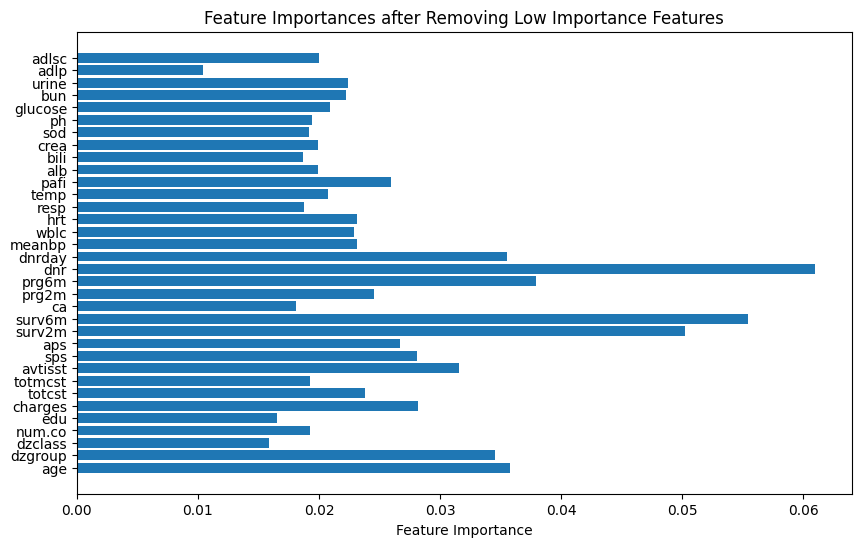

Number of features after removing low importance features: 34


In [ ]:
# delete columns with low feature importance
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
def delete_low_importance_features(data, target_cols, threshold=0.01):
    """
    Delete columns with low feature importance based on Random Forest Classifier.
    
    Parameters:
    -----------
    data : pd.DataFrame
        The input DataFrame containing features and target.
    target_cols : list
        The names of the target columns.
    threshold : float
        The minimum feature importance value to retain a feature.
        
    Returns:
    --------
    pd.DataFrame
        The DataFrame with low importance features removed.
    """
    oe = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
    X = data.drop(columns=target_cols)
    y = data[target_cols[0]]  # Use the first target column for feature importance

    # Encode categorical columns
    X_encoded = X.copy()
    cat_cols = X_encoded.select_dtypes(include=['object', 'category']).columns
    if len(cat_cols) > 0:
        X_encoded[cat_cols] = oe.fit_transform(X_encoded[cat_cols])

    # Fit Random Forest Classifier
    model = RandomForestClassifier(random_state=42)
    model.fit(X_encoded, y)

    # Get feature importances
    importances = model.feature_importances_

    # Select features above the threshold
    selected_features = X_encoded.columns[importances > threshold]
    
    return data[selected_features.tolist() + target_cols], model.feature_importances_
# Only drop columns that exist in the DataFrame
target_cols = [col for col in ['death', 'sfdm2', 'hospdead'] if col in data_no_outliers.columns]
data_no_low_importance, importance = delete_low_importance_features(data_no_outliers, target_cols=target_cols, threshold=0.01)

# plot feature importances for selected features only
selected_features = data_no_low_importance.drop(columns=['death']).columns

# Only drop columns that exist in the DataFrame for original_features
original_features = data_no_outliers.drop(columns=target_cols).columns

# Get importances for selected_features by matching their positions in original_features
selected_importances = [importance[original_features.get_loc(col)] for col in selected_features if col in original_features]

# Ensure selected_features and selected_importances have the same length
selected_features_plot = [col for col in selected_features if col in original_features]

plt.figure(figsize=(10, 6))
plt.barh(selected_features_plot, selected_importances)
plt.xlabel('Feature Importance')
plt.title('Feature Importances after Removing Low Importance Features')
plt.show()
print(f"Number of features after removing low importance features: {len(selected_features_plot)}")

In [ ]:
data_no_low_importance

,age,dzgroup,dzclass,num.co,edu,charges,totcst,totmcst,avtisst,sps,...,sod,ph,glucose,bun,urine,adlp,adlsc,death,sfdm2,hospdead
0,62.84998,Lung Cancer,Cancer,0,11.0,9715.0,6208.4922,0.0,7.0,33.898438,...,141.0,7.459961,152.0,8.0,540.0,7.0,7.000000,0,adl>=4 (>=5 if sur),0
1,60.33899,Cirrhosis,COPD/CHF/Cirrhosis,2,12.0,34496.0,8313.8281,0.0,29.0,52.695312,...,132.0,7.25,103.0,57.0,705.0,0.0,1.000000,1,<2 mo. follow-up,1
2,52.74698,Cirrhosis,COPD/CHF/Cirrhosis,2,12.0,41094.0,1585.3633,0.0,13.0,20.5,...,134.0,7.459961,417.0,45.0,1100.0,1.0,0.000000,1,<2 mo. follow-up,0
3,42.38498,Lung Cancer,Cancer,2,11.0,3075.0,1585.3633,0.0,7.0,20.097656,...,139.0,7.529297,299.0,7.0,1975.0,0.0,0.000000,1,no(M2 and SIP pres),0
4,79.88495,ARF/MOSF w/Sepsis,ARF/MOSF,1,12.0,50127.0,130006.375,0.0,18.666656,23.5,...,143.0,7.509766,417.0,15.0,1910.0,5.0,2.000000,0,no(M2 and SIP pres),0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8814,66.07300,ARF/MOSF w/Sepsis,ARF/MOSF,1,8.0,52870.0,34329.3125,32042.75,20.333328,16.296875,...,131.0,7.459961,188.0,21.0,2900.0,0.0,0.000000,0,no(M2 and SIP pres),0
8815,55.15399,Coma,Coma,1,11.0,35377.0,23558.5,22131.0469,18.0,25.796875,...,135.0,7.289062,190.0,49.0,0.0,0.0,0.000000,0,SIP>=30,0
8816,70.38196,ARF/MOSF w/Sepsis,ARF/MOSF,1,11.0,46564.0,31409.0156,31131.25,23.0,22.699219,...,139.0,7.379883,189.0,60.0,3900.0,0.0,2.525391,0,no(M2 and SIP pres),0
8817,47.01999,MOSF w/Malig,ARF/MOSF,1,13.0,58439.0,0.0,0.0,35.5,40.195312,...,135.0,7.469727,246.0,55.0,2830.0,1.0,0.000000,1,<2 mo. follow-up,1


In [ ]:
cat_cols = data_no_low_importance.select_dtypes(include=['object', 'category']).columns
cat_cols

Index(['dzgroup', 'dzclass', 'edu', 'charges', 'totcst', 'totmcst', 'avtisst',
       'sps', 'aps', 'surv2m', 'surv6m', 'ca', 'prg2m', 'prg6m', 'dnr',
       'dnrday', 'meanbp', 'wblc', 'hrt', 'resp', 'temp', 'pafi', 'alb',
       'bili', 'crea', 'sod', 'ph', 'glucose', 'bun', 'urine', 'adlp',
       'sfdm2'],
      dtype='object')

In [ ]:
from sklearn.preprocessing import PolynomialFeatures, OrdinalEncoder, OneHotEncoder
NominalEncoder_list = ['dzgroup', 'dzclass','ca', 'dnr']
map_information = {'nominal':{},'ordinal':{}}
# check the number of unique values in each categorical column
for col in cat_cols:
    print(f"Number of unique values in {col}: {data_no_low_importance[col].nunique()}")

Number of unique values in dzgroup: 8
Number of unique values in dzclass: 4
Number of unique values in edu: 30
Number of unique values in charges: 8242
Number of unique values in totcst: 7917
Number of unique values in totmcst: 5255
Number of unique values in avtisst: 344
Number of unique values in sps: 581
Number of unique values in aps: 119
Number of unique values in surv2m: 935
Number of unique values in surv6m: 930
Number of unique values in ca: 3
Number of unique values in prg2m: 49
Number of unique values in prg6m: 84
Number of unique values in dnr: 3
Number of unique values in dnrday: 166
Number of unique values in meanbp: 160
Number of unique values in wblc: 477
Number of unique values in hrt: 182
Number of unique values in resp: 63
Number of unique values in temp: 95
Number of unique values in pafi: 1400
Number of unique values in alb: 59
Number of unique values in bili: 273
Number of unique values in crea: 127
Number of unique values in sod: 60
Number of unique values in ph: 

In [ ]:
# encode nominal encoder list as onehot encoder
for col in NominalEncoder_list:
    ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
    encoded_col = ohe.fit_transform(data_no_low_importance[[col]])
    encoded_col_df = pd.DataFrame(encoded_col, columns=[f"{col}_{i}" for i in range(encoded_col.shape[1])])
    data_no_low_importance = pd.concat([data_no_low_importance, encoded_col_df], axis=1)
    data_no_low_importance.drop(columns=[col], inplace=True)
    # record the mapping information
    map_information['nominal'][col] = ohe.categories_[0].tolist()
map_information

{'nominal': {'dzgroup': ['ARF/MOSF w/Sepsis',
   'CHF',
   'COPD',
   'Cirrhosis',
   'Colon Cancer',
   'Coma',
   'Lung Cancer',
   'MOSF w/Malig'],
  'dzclass': ['ARF/MOSF', 'COPD/CHF/Cirrhosis', 'Cancer', 'Coma'],
  'ca': ['metastatic', 'no', 'yes'],
  'dnr': ['dnr after sadm', 'dnr before sadm', 'no dnr']},
 'ordinal': {}}

In [ ]:
# encode ordinal encoder list and numeric columns
for col in cat_cols:
    # Skip columns that have been one-hot encoded and dropped, or are not present
    if col in NominalEncoder_list or col not in data_no_low_importance.columns:
        continue
    if data_no_low_importance[col].nunique() <= 30:  # Ordinal encoding for categorical columns (all with <= 30 unique values after manual check)
        oe = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
        data_no_low_importance[col] = oe.fit_transform(data_no_low_importance[[col]])
        # record the mapping information as a dictionary: number value -> original value
        map_information['ordinal'][col] = {i: v for i, v in enumerate(oe.categories_[0])}
    else:
        data_no_low_importance[col] = data_no_low_importance[col].astype(float)  # Convert to float since mostly stated as float in the codebook
print(map_information)
# Only show columns that still exist
remaining_cat_cols = [col for col in cat_cols if col in data_no_low_importance.columns]
data_no_low_importance[remaining_cat_cols]

{'nominal': {'dzgroup': ['ARF/MOSF w/Sepsis', 'CHF', 'COPD', 'Cirrhosis', 'Colon Cancer', 'Coma', 'Lung Cancer', 'MOSF w/Malig'], 'dzclass': ['ARF/MOSF', 'COPD/CHF/Cirrhosis', 'Cancer', 'Coma'], 'ca': ['metastatic', 'no', 'yes'], 'dnr': ['dnr after sadm', 'dnr before sadm', 'no dnr']}, 'ordinal': {'edu': {0: 0.0, 1: 1.0, 2: 2.0, 3: 3.0, 4: 4.0, 5: 5.0, 6: 6.0, 7: 7.0, 8: 8.0, 9: 9.0, 10: 10.0, 11: 11.0, 12: 12.0, 13: 13.0, 14: 14.0, 15: 15.0, 16: 16.0, 17: 17.0, 18: 18.0, 19: 19.0, 20: 20.0, 21: 21.0, 22: 22.0, 23: 23.0, 24: 24.0, 25: 26.0, 26: 27.0, 27: 28.0, 28: 30.0, 29: 31.0}, 'adlp': {0: 0.0, 1: 1.0, 2: 2.0, 3: 3.0, 4: 4.0, 5: 5.0, 6: 6.0, 7: 7.0}, 'sfdm2': {0: '<2 mo. follow-up', 1: 'Coma or Intub', 2: 'SIP>=30', 3: 'adl>=4 (>=5 if sur)', 4: 'no(M2 and SIP pres)'}}}


,edu,charges,totcst,totmcst,avtisst,sps,aps,surv2m,surv6m,prg2m,...,alb,bili,crea,sod,ph,glucose,bun,urine,adlp,sfdm2
0,11.0,9715.0,6208.4922,0.0000,7.000000,33.898438,20.0,0.262939,0.036995,0.50,...,1.799805,0.199982,1.199951,141.0,7.459961,152.0,8.0,540.0,7.0,3.0
1,12.0,34496.0,8313.8281,0.0000,29.000000,52.695312,74.0,0.001000,0.000000,0.00,...,4.699219,0.799927,5.500000,132.0,7.250000,103.0,57.0,705.0,0.0,0.0
2,12.0,41094.0,1585.3633,0.0000,13.000000,20.500000,45.0,0.790894,0.664917,0.75,...,3.000000,2.199707,2.000000,134.0,7.459961,417.0,45.0,1100.0,1.0,0.0
3,11.0,3075.0,1585.3633,0.0000,7.000000,20.097656,19.0,0.698975,0.411987,0.90,...,3.199707,0.599976,0.799927,139.0,7.529297,299.0,7.0,1975.0,0.0,4.0
4,12.0,50127.0,130006.3750,0.0000,18.666656,23.500000,30.0,0.634888,0.532959,0.90,...,2.399902,1.099854,0.799927,143.0,7.509766,417.0,15.0,1910.0,5.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8814,8.0,52870.0,34329.3125,32042.7500,20.333328,16.296875,22.0,0.852905,0.801880,0.80,...,3.699707,0.399963,1.099854,131.0,7.459961,188.0,21.0,2900.0,0.0,4.0
8815,11.0,35377.0,23558.5000,22131.0469,18.000000,25.796875,31.0,0.553955,0.485962,0.50,...,2.699707,2.000000,5.899414,135.0,7.289062,190.0,49.0,0.0,0.0,2.0
8816,11.0,46564.0,31409.0156,31131.2500,23.000000,22.699219,39.0,0.741943,0.660889,0.90,...,4.199219,0.399963,2.699707,139.0,7.379883,189.0,60.0,3900.0,0.0,4.0
8817,13.0,58439.0,0.0000,0.0000,35.500000,40.195312,51.0,0.177979,0.091995,0.09,...,1.199951,0.399963,3.500000,135.0,7.469727,246.0,55.0,2830.0,1.0,0.0


In [ ]:
df=data_no_low_importance
df

,age,num.co,edu,charges,totcst,totmcst,avtisst,sps,aps,surv2m,...,dzclass_0,dzclass_1,dzclass_2,dzclass_3,ca_0,ca_1,ca_2,dnr_0,dnr_1,dnr_2
0,62.84998,0,11.0,9715.0,6208.4922,0.0000,7.000000,33.898438,20.0,0.262939,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1,60.33899,2,12.0,34496.0,8313.8281,0.0000,29.000000,52.695312,74.0,0.001000,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
2,52.74698,2,12.0,41094.0,1585.3633,0.0000,13.000000,20.500000,45.0,0.790894,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3,42.38498,2,11.0,3075.0,1585.3633,0.0000,7.000000,20.097656,19.0,0.698975,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,79.88495,1,12.0,50127.0,130006.3750,0.0000,18.666656,23.500000,30.0,0.634888,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8814,66.07300,1,8.0,52870.0,34329.3125,32042.7500,20.333328,16.296875,22.0,0.852905,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
8815,55.15399,1,11.0,35377.0,23558.5000,22131.0469,18.000000,25.796875,31.0,0.553955,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
8816,70.38196,1,11.0,46564.0,31409.0156,31131.2500,23.000000,22.699219,39.0,0.741943,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
8817,47.01999,1,13.0,58439.0,0.0000,0.0000,35.500000,40.195312,51.0,0.177979,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0


# Data Visualization

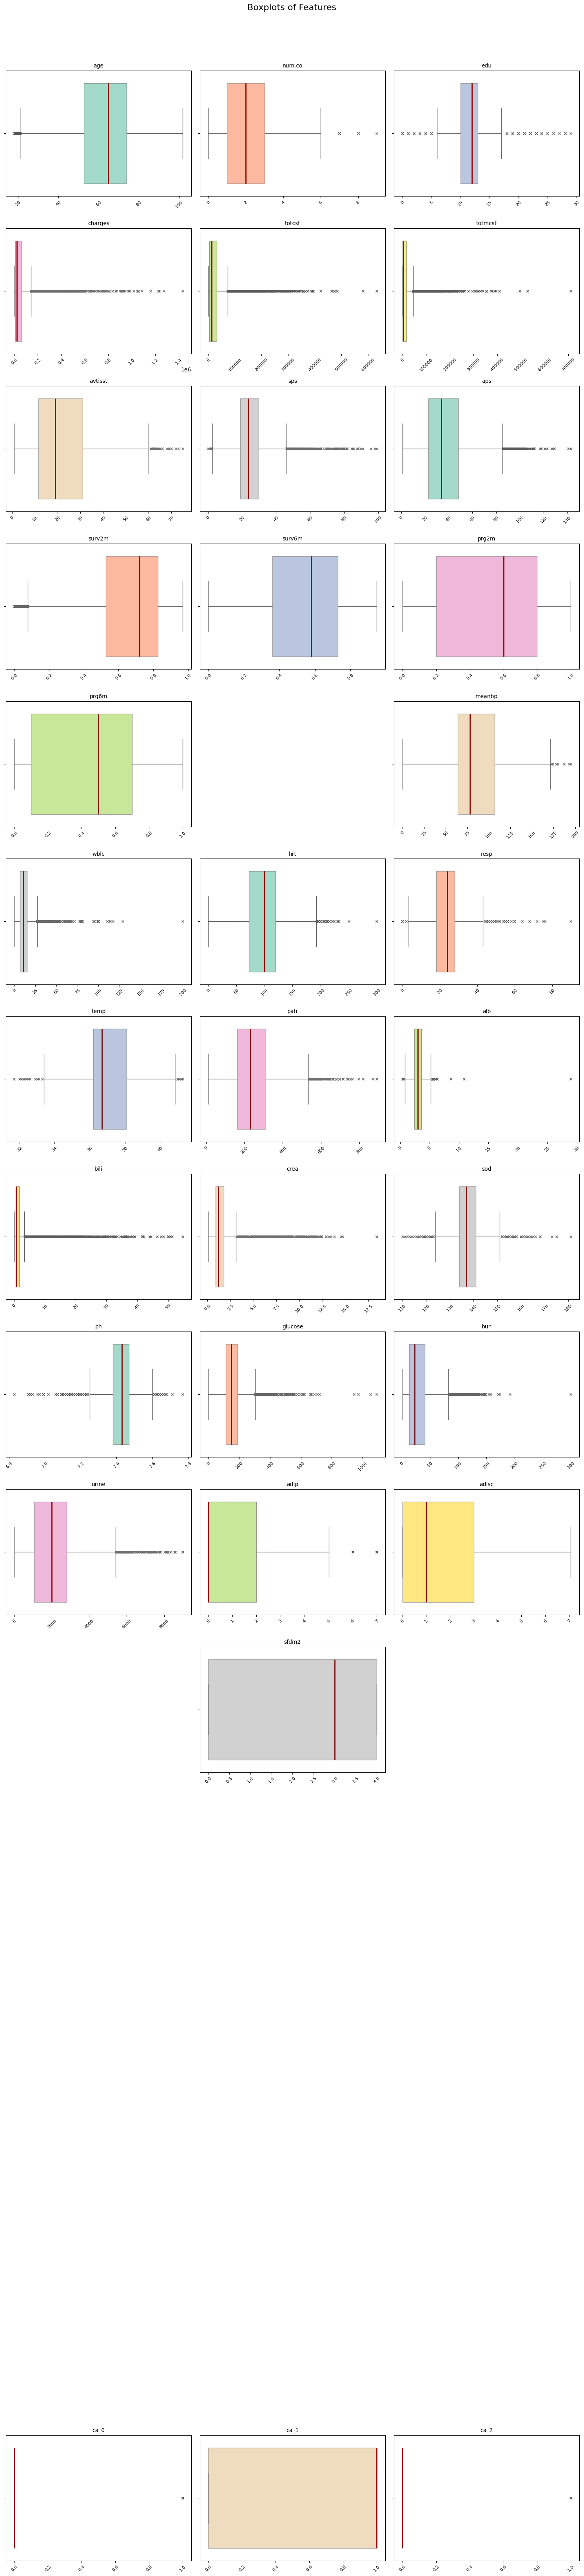

In [ ]:
n_cols = 3
n_rows = (len(df.columns) + n_cols - 1) // n_cols
plt.figure(figsize=(n_cols * 5, n_rows * 4))
palette = sns.color_palette("Set2")

for i, column in enumerate(df.columns):
    if column.startswith('dnr') or 'dea' in column or column.startswith('dz'):
        continue
    plt.subplot(n_rows, n_cols, i + 1)
    sns.boxplot(x=df[column], color=palette[i % len(palette)],
                flierprops={"marker": "x", "markerfacecolor": "red", "markersize": 4},
                boxprops={"facecolor": palette[i % len(palette)], "alpha": 0.6},
                medianprops={"color": "darkred", "linewidth": 2})
    plt.title(column, fontsize=10)
    plt.xlabel("")
    plt.xticks(rotation=45, fontsize=8)
    plt.tight_layout()

plt.suptitle("Boxplots of Features", fontsize=16, y=1.02)
plt.show()

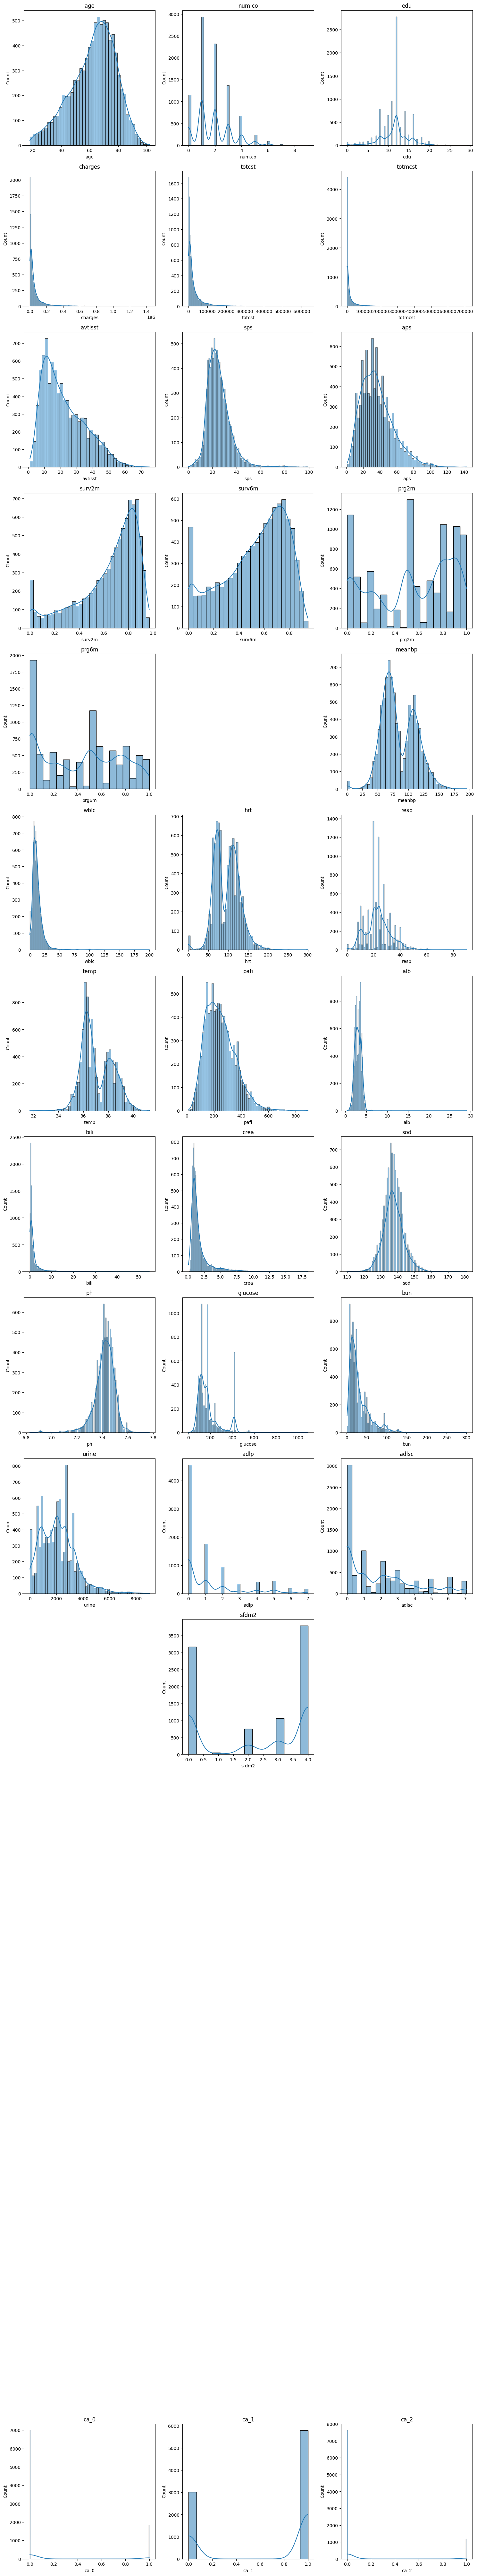

In [ ]:
plt.figure(figsize=(n_cols * 5, n_rows * 5))
for i, column in enumerate(df.columns):
    if column.startswith('dnr') or 'dea' in column or column.startswith('dz'):
        continue
    plt.subplot(n_rows, n_cols, i+1)
    sns.histplot(df[column], kde=True)
    plt.title(column)

plt.tight_layout()
plt.show()

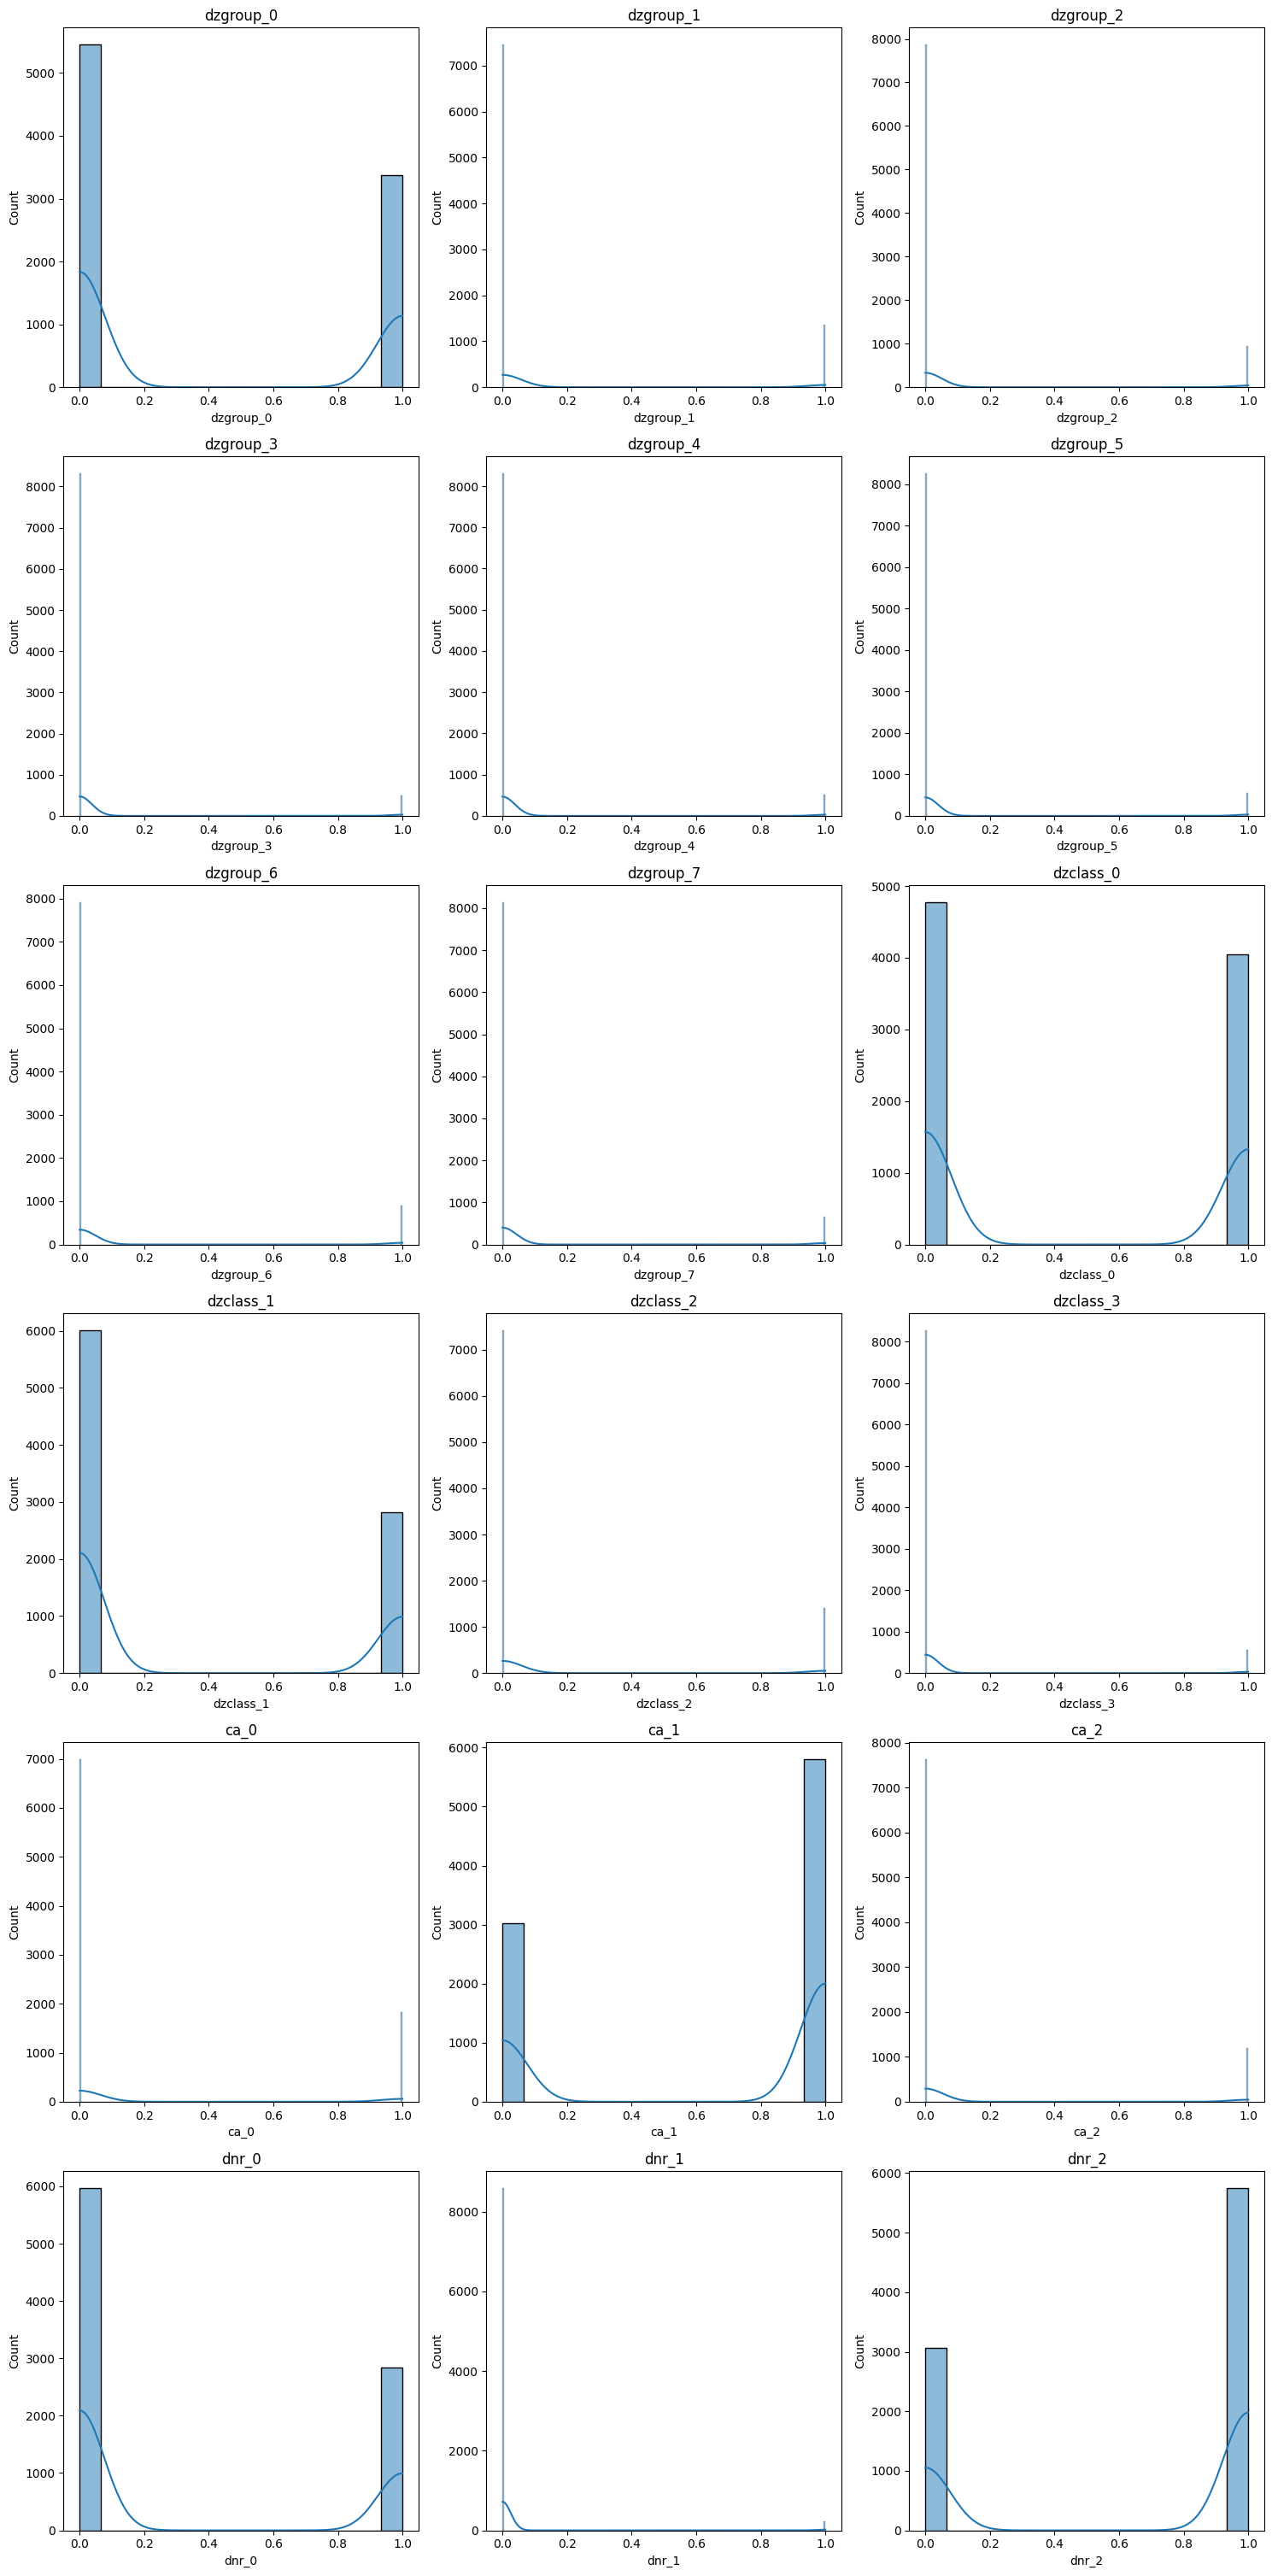

In [ ]:
# Set grid size based on number of nominal columns
num_nominal = len(map_information['nominal'])
n_cols_nominal = 3
n_rows_nominal = (num_nominal + n_cols_nominal - 1) // n_cols_nominal

plt.figure(figsize=(n_cols_nominal*5, n_rows_nominal*5))
plot_idx = 1
for nominal_col in map_information['nominal'].keys():
    hist_table = {}
    for column in df.columns:
        if nominal_col in column:
            hist_table[column] = df[column].sum()
    plt.subplot(n_rows_nominal, n_cols_nominal, plot_idx)
    sns.barplot(x=list(hist_table.keys()), y=list(hist_table.values()), palette=palette)
    plt.title(nominal_col)
    plt.xticks(rotation=45, fontsize=8)
    plot_idx += 1

plt.tight_layout()
plt.show()

# Clustering Analysis

# Prediction: Training and Testing

# Evaluation and Choice of Prediction Model

# Open-Ended Exploration